# Machine Learning Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os

## Load Datasets

In [2]:
dir_name = 'data_files/'

X_train = pd.read_csv(dir_name + 'preprocessed_X_train2.csv')
y_train = pd.read_csv(dir_name + 'y_train2.csv')
X_test = pd.read_csv(dir_name + 'preprocessed_X_test2.csv')
y_test = pd.read_csv(dir_name + 'y_test2.csv')

In [3]:
X_train.columns

Index(['room_shared', 'room_private', 'person_capacity', 'host_is_superhost',
       'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'dist', 'metro_dist', 'attr_index', 'rest_index', 'lng',
       'lat', 'is_weekend', 'room_type_Private room', 'room_type_Shared room',
       'city_Athens', 'city_Barcelona', 'city_Berlin', 'city_Budapest',
       'city_Lisbon', 'city_London', 'city_Paris', 'city_Rome', 'city_Vienna'],
      dtype='object')

## Models Experiment

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_squared_error, r2_score

In [5]:
# Plot y_predict x y_actual

def plot_predict_actual(y_actual, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_actual, y_pred)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.show()

### Machine Learning Models

### Random Forest

In [6]:
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,  # Reduce iterations for quicker results
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train.squeeze())

print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


Evaluation

In [7]:
y_train_predict = random_search.best_estimator_.predict(X_train)
y_test_predict = random_search.best_estimator_.predict(X_test)

In [8]:
mse_train = mean_squared_error(y_train, y_train_predict)
r2_train = r2_score(y_train, y_train_predict)

mse_test = mean_squared_error(y_test, y_test_predict)
r2_test = r2_score(y_test, y_test_predict)

print("🟢 Train - MSE: ", mse_train)
print("🔵 Test - MSE: ", mse_test)
print("🟢 Train - R2: ", r2_train)
print("🔵 Test - R2: ", r2_test)

🟢 Train - MSE:  0.19401544475157356
🔵 Test - MSE:  42345.69405390938
🟢 Train - R2:  0.9999980776704708
🔵 Test - R2:  0.6556926844367277


Feature Importance

In [9]:
importances = random_search.best_estimator_.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
14,lat,0.154525
13,lng,0.131535
11,attr_index,0.129024
9,dist,0.114648
12,rest_index,0.104314
10,metro_dist,0.074091
8,bedrooms,0.054793
2,person_capacity,0.051315
7,guest_satisfaction_overall,0.042463
1,room_private,0.020264


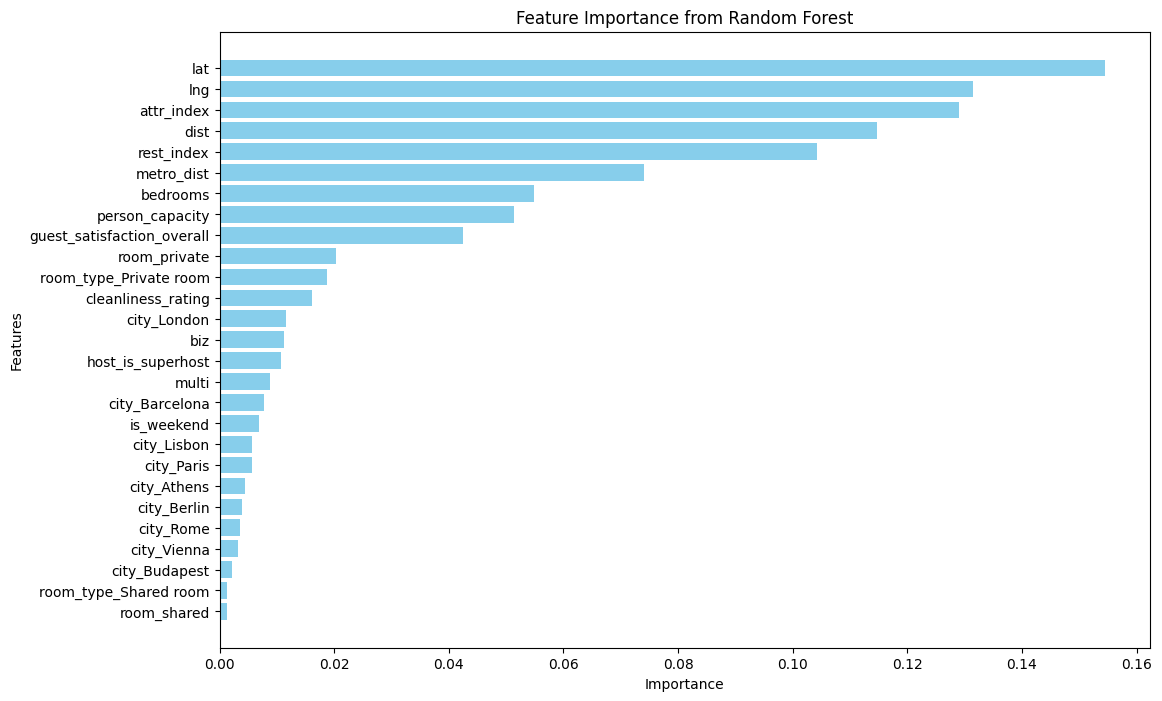

In [10]:
plt.figure(figsize=(12, 8))
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.show()

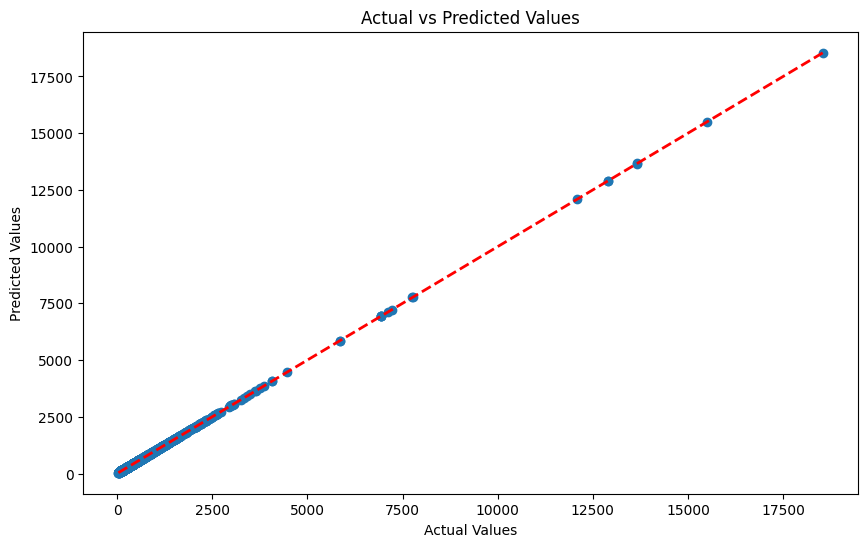

In [11]:
plot_predict_actual(y_actual=y_train, y_pred=y_train_predict)

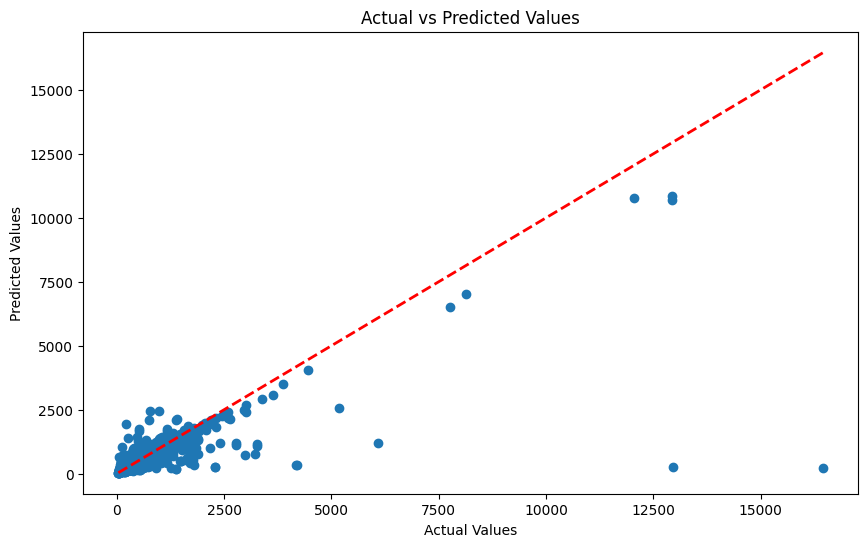

In [12]:
plot_predict_actual(y_actual=y_test, y_pred=y_test_predict)

Save the model

In [15]:
os.makedirs('models', exist_ok=True)

joblib.dump(random_search.best_estimator_, 'models/random_search_best_model_1.pkl')
print("Model saved successfully in 'models/random_search_best_model_1.pkl'")

#joblib.dump(random_search.best_estimator_, 'models/random_search_best_model_1.pkl')
# Load the model later
#best_model = joblib.load('models/random_search_best_model.pkl')

Model saved successfully in 'models/random_search_best_model_1.pkl'


### Stacking

In [27]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

estimators = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=None)),
    ('gb', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1)),
    ('ridge', Ridge(alpha=1.0))
]

stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())
stacking_model.fit(X_train, y_train)


c:\Users\fizuf\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:1060: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


StackingRegressor(estimators=[('rf', RandomForestRegressor(n_estimators=200)),
                              ('gb',
                               GradientBoostingRegressor(n_estimators=200)),
                              ('ridge', Ridge())],
                  final_estimator=Ridge())

In [28]:
y_train_sm = stacking_model.predict(X_train)
y_test_sm = stacking_model.predict(X_test)

sm_mae = mean_squared_error(y_train, y_train_sm)
sm_r2 = r2_score(y_test, y_test_sm)

print('MAE: ', sm_mae)
print('R2: ', sm_r2)

MAE:  15472.180450746037
R2:  0.5869687458483734
